# VQE implementation for a helium atom using 8 qubits

## 1-Importing libraries

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit.visualization import circuit_drawer
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
import time
from IPython.display import clear_output

## 2-Plots & visualizations 

In [8]:
class VQEVisualizer:
    """Visualizer for tracking and displaying VQE optimization progress."""
    
    def __init__(self, target_energy=-2.903724, live_plotting=True, plot_frequency=10):
        self.reset()
        self.target_energy = target_energy
        self.live_plotting = live_plotting
        self.plot_frequency = plot_frequency
        
    def callback(self, xk, energy):
        """Store optimization progress."""
        self.current_energy = energy
        self.energies.append(energy)
        self.iteration += 1
        
        current_time = time.time()
        self.iteration_times.append(current_time - self.start_time)
        
        if energy < self.best_energy:
            self.best_energy = energy
            self.best_params = xk.copy()
            self.best_iteration = self.iteration
        
        if self.live_plotting and self.iteration % self.plot_frequency == 0:
            clear_output(wait=True)
            self.plot_convergence()
            print(f"\nIteration {self.iteration}")
            print(f"Current Energy: {energy:.6f} Hartree")
            print(f"Best Energy: {self.best_energy:.6f} Hartree")
            print(f"Target Energy: {self.target_energy:.6f} Hartree")
            plt.show()
        
        return False
    
    def plot_convergence(self, figsize=(12, 8)):
        """Plot optimization convergence."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # Energy convergence plot
        ax1.plot(self.energies, 'b-', label='Energy', linewidth=2)
        ax1.axhline(y=self.target_energy, color='r', linestyle='--', 
                   label=f'Target Energy: {self.target_energy:.6f}')
        ax1.axhline(y=self.best_energy, color='g', linestyle=':', 
                   label=f'Best Energy: {self.best_energy:.6f}')
        
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Energy (Hartree)')
        ax1.set_title('VQE Energy Convergence')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Error convergence plot
        errors = np.abs(np.array(self.energies) - self.target_energy)
        ax2.semilogy(errors, 'b-', label='|E - E_target|', linewidth=2)
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Absolute Error (Hartree)')
        ax2.set_title('Error Convergence')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        return fig
    
    def reset(self):
        """Reset visualizer state."""
        self.energies = []
        self.iteration = 0
        self.iteration_times = []
        self.start_time = time.time()
        self.current_energy = float('inf')
        self.best_energy = float('inf')
        self.best_params = None
        self.best_iteration = 0
    def visualize_electronic_structure(params, n_qubits, sampler, shots=1000):
        """Visualizes the electronic structure of helium based on VQE results."""
        qc = create_ansatz_circuit(n_qubits, params)
        job = sampler.run([qc], shots=shots)
        quasi_dists = job.result().quasi_dists[0]
    
        # Create figure for electronic structure
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    
        # Generate electron density cloud
        phi = np.linspace(0, 2*np.pi, 100)
        theta = np.linspace(0, np.pi, 50)
        phi, theta = np.meshgrid(phi, theta)
    
        # Calculate spherical harmonics for 1s orbital
        r = 1.0  # Normalized radius
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
    
        # Plot electron density
        density = np.exp(-2 * np.sqrt(x**2 + y**2 + z**2))
        ax.plot_surface(x, y, z, facecolors=plt.cm.viridis(density), alpha=0.3)
    
        # Plot nucleus
        ax.scatter([0], [0], [0], color='red', s=200, label='He nucleus')
    
        ax.set_title('Helium Atom Electronic Structure')
        ax.set_xlabel('x (a.u.)')
        ax.set_ylabel('y (a.u.)')
        ax.set_zlabel('z (a.u.)')
        ax.legend()
    
        return fig, quasi_dists

    def visualize_measurements(quasi_dists):
        """Creates a bar plot of the measurement distribution."""
        fig = plt.figure(figsize=(25, 5))
        states = list(quasi_dists.keys())
        probabilities = list(quasi_dists.values())
    
        # Convert states to binary strings for better readability
        state_labels = [format(state, '04b') for state in states]
    
        plt.bar(state_labels, probabilities)
        plt.title('Final Measurement Distribution')
        plt.xlabel('State (binary)')
        plt.ylabel('Probability')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
        return fig


## 3-Generating the hamiltonian operator for the Heluim atom

In [13]:
class HeliumHamiltonianGenerator:
    """Generates the Hamiltonian for the helium atom using STO-3G basis."""
    
    def __init__(self):
        self.Z = 2  # Nuclear charge for helium
        self.alpha = [6.36242139, 1.158923, 0.31364979]  # STO-3G basis parameters
        self.coeff = [0.15432897, 0.53532814, 0.44463454]
        
    def generate_orbital_indices(self, n_orbitals):
        """Generate mapping of spatial orbitals to qubit indices."""
        self.orbital_to_qubit = {}
        for i in range(n_orbitals):
            self.orbital_to_qubit[i] = {
                'up': 2*i,
                'down': 2*i + 1
            }
        return 2 * n_orbitals
    
    def get_one_electron_integrals(self, n_orbitals):
        """Calculate one-electron integrals."""
        h_mat = np.zeros((n_orbitals, n_orbitals))
        for i in range(n_orbitals):
            for j in range(n_orbitals):
                if i == j:
                    h_mat[i,j] = -self.Z**2/2
        return h_mat
    
    def get_two_electron_integrals(self, n_orbitals):
        """Calculate two-electron integrals."""
        g_mat = np.zeros((n_orbitals, n_orbitals, n_orbitals, n_orbitals))
        for i, j, k, l in product(range(n_orbitals), repeat=4):
            if i == j and k == l:
                g_mat[i,j,k,l] = 5/8 * self.Z
        return g_mat
    
    def generate_hamiltonian_terms(self, n_orbitals=2):
        """Generate Hamiltonian terms in Pauli basis."""
        n_qubits = self.generate_orbital_indices(n_orbitals)
        h_mat = self.get_one_electron_integrals(n_orbitals)
        g_mat = self.get_two_electron_integrals(n_orbitals)
        
        hamiltonian_terms = {}
        
        # One-electron terms
        for i in range(n_orbitals):
            for spin in ['up', 'down']:
                qubit = self.orbital_to_qubit[i][spin]
                pauli_str = 'I' * qubit + 'Z' + 'I' * (n_qubits - qubit - 1)
                hamiltonian_terms[pauli_str] = h_mat[i,i]/2
        
        # Two-electron terms
        for i, j, k, l in product(range(n_orbitals), repeat=4):
            if g_mat[i,j,k,l] != 0:
                for spin1, spin2 in product(['up', 'down'], repeat=2):
                    q1 = self.orbital_to_qubit[i][spin1]
                    q2 = self.orbital_to_qubit[j][spin2]
                    pauli_str = 'Z' * q1 + 'Z' * q2
                    hamiltonian_terms[pauli_str] = g_mat[i,j,k,l]/4
        
        # Nuclear repulsion
        hamiltonian_terms['I' * n_qubits] = self.Z * (self.Z - 1) / 2
        
        return hamiltonian_terms, n_qubits


## 4-Ansatz 

In [10]:
def create_ansatz_circuit(n_qubits, params):
    """Creates a UCC-inspired ansatz for helium."""
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    
    # Reference state preparation
    for i in range(2):
        qc.x(i)
    
    param_idx = 0
    n_layers = 3
    
    for layer in range(n_layers):
        # Single excitations
        for i in range(n_qubits):
            qc.rx(params[param_idx], i)
            param_idx += 1
            qc.rz(params[param_idx], i)
            param_idx += 1
        
        # Double excitations
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            qc.rz(params[param_idx], i+1)
            param_idx += 1
            qc.cx(i, i+1)
        
        # Orbital rotations
        for i in range(n_qubits-1):
            qc.cx(i, i+1)
    
    qc.measure(qr, cr)
    return qc


## 5-Quantum circuit execution & expectations

In [11]:
def get_expectation(params, hamiltonian, n_qubits, sampler=None, shots=4000):
    """Calculates expected energy using the Sampler primitive."""
    if sampler is None:
        sampler = Sampler()
    
    qc = create_ansatz_circuit(n_qubits, params)
    measurement_circuits = []
    coefficients = []
    
    for pauli_string, coeff in hamiltonian.items():
        meas_qc = qc.copy()
        
        for i, p in enumerate(pauli_string):
            if p == 'X':
                meas_qc.h(i)
            elif p == 'Y':
                meas_qc.sdg(i)
                meas_qc.h(i)
        
        meas_qc.measure(range(n_qubits), range(n_qubits))
        measurement_circuits.append(meas_qc)
        coefficients.append(coeff)
    
    job = sampler.run(measurement_circuits, shots=shots)
    results = job.result().quasi_dists
    
    expectation = 0.0
    for result, coeff in zip(results, coefficients):
        pauli_exp = 0.0
        for bitstring, prob in result.items():
            binary = format(bitstring, f'0{n_qubits}b')
            parity = (-1)**sum(int(bit) for bit in binary)
            pauli_exp += prob * parity
        expectation += coeff * pauli_exp
    
    return expectation



## 6-Executing the VQE 


Iteration 300
Current Energy: -2.891438 Hartree
Best Energy: -2.953656 Hartree
Target Energy: -2.903724 Hartree


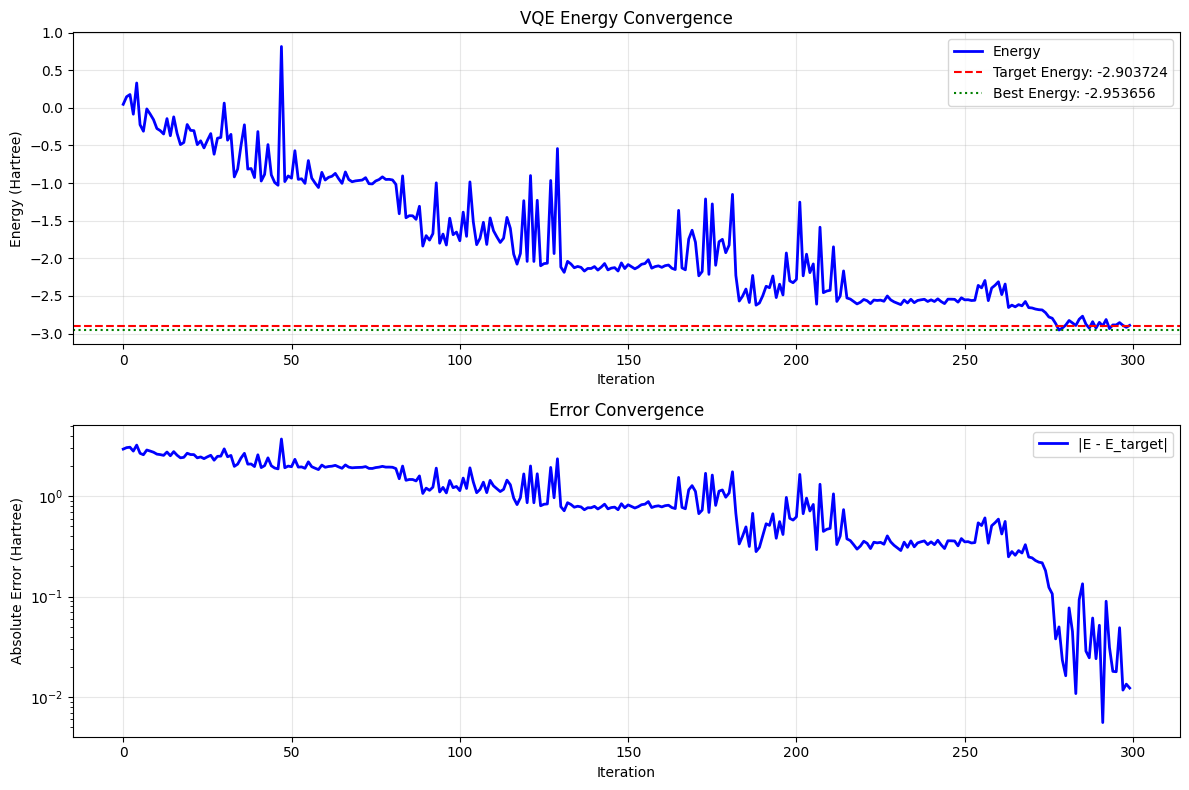


Results:
Ground State Energy: -2.953656 Hartree
Experimental Value: -2.903724 Hartree
Absolute Error: 0.049932 Hartree

Optimal Circuit:


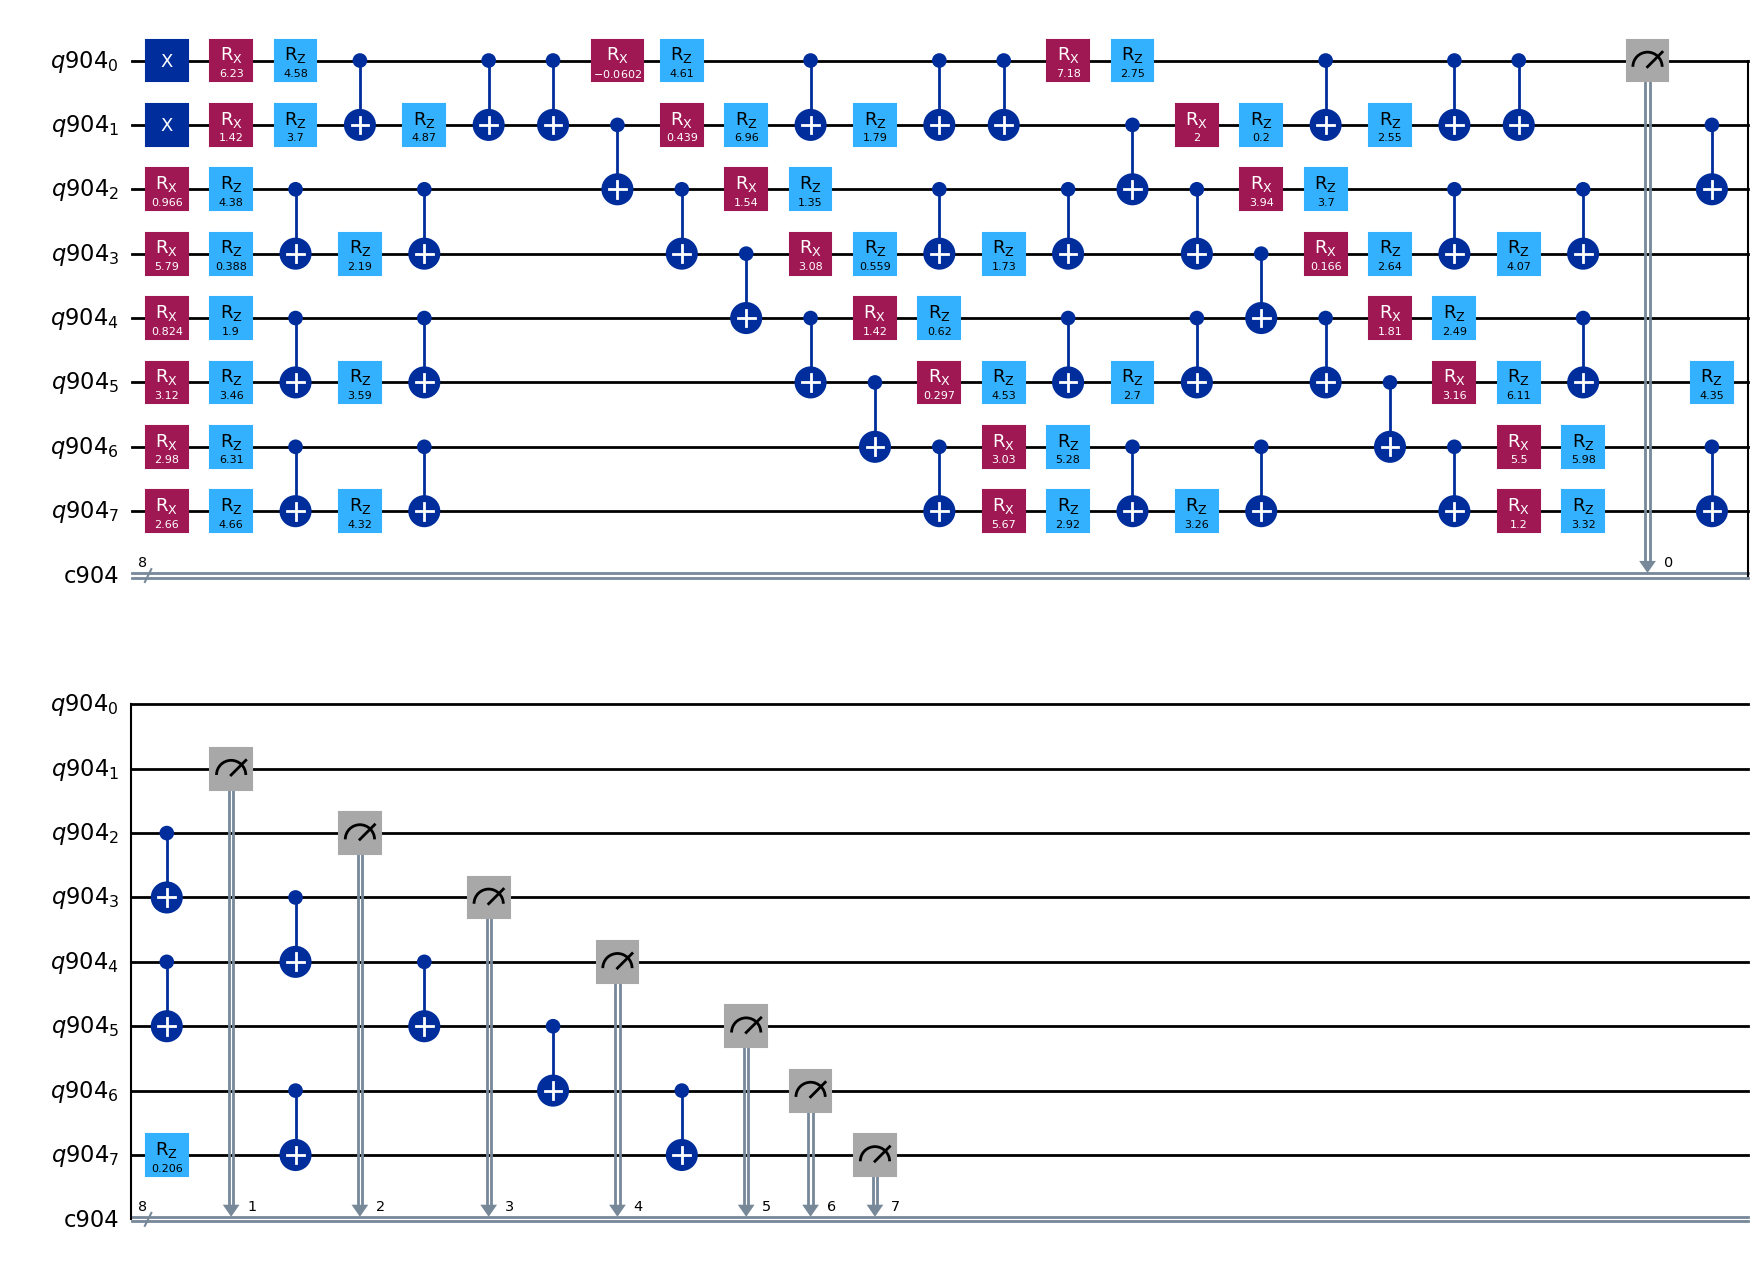

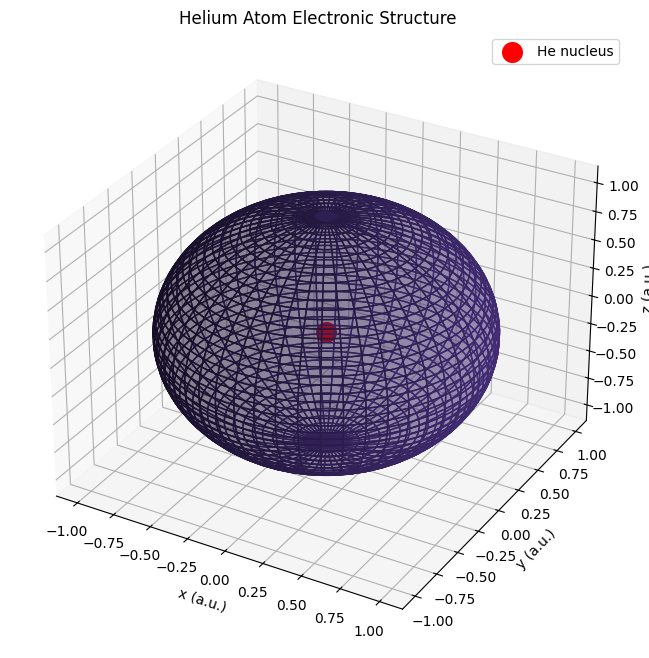

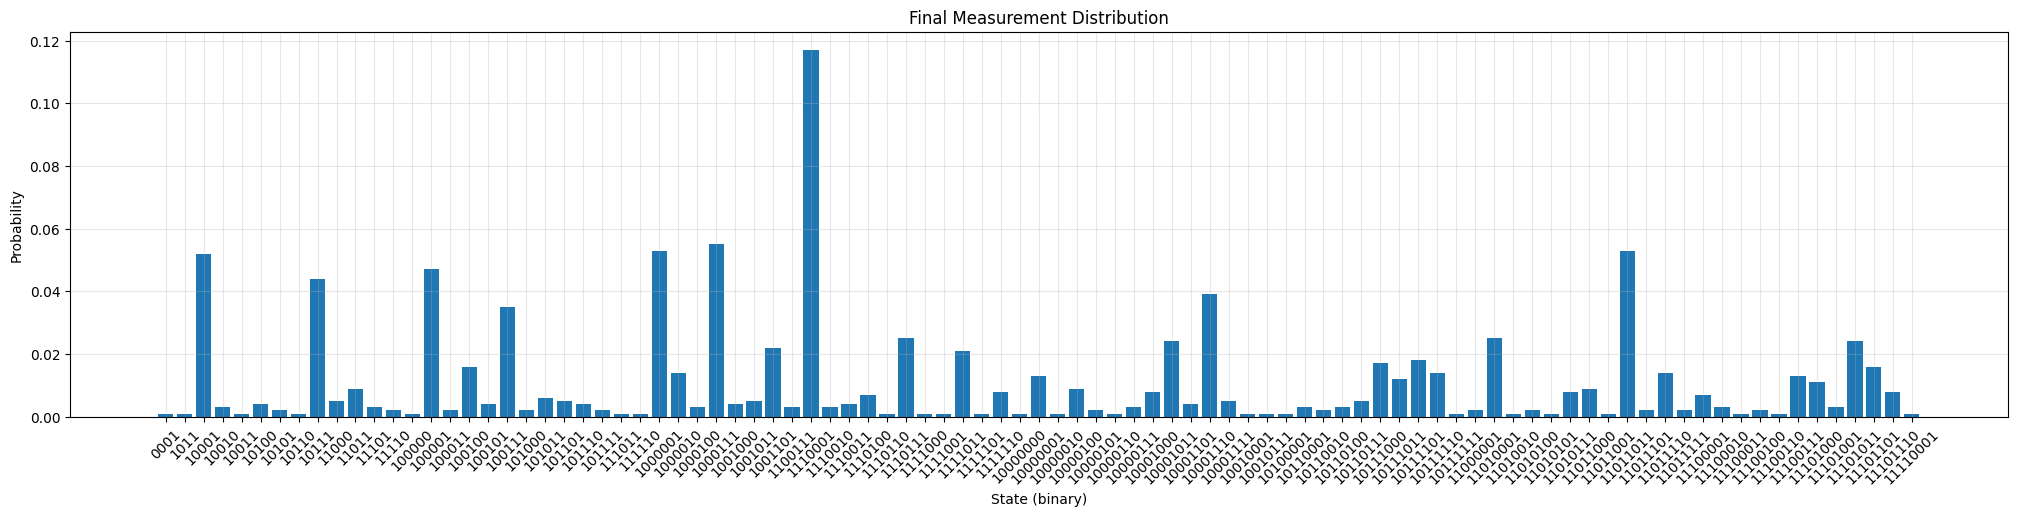

In [14]:
def main():
    # Initialize components
    ham_gen = HeliumHamiltonianGenerator()
    hamiltonian, n_qubits = ham_gen.generate_hamiltonian_terms(n_orbitals=4)
    visualizer = VQEVisualizer()
    sampler = Sampler()
    
    print(f"Using {n_qubits} qubits to represent {n_qubits//2} spin orbitals")
    
    # Calculate parameters
    n_params = 3 * (2 * n_qubits + (n_qubits // 2) + (n_qubits - 1))
    initial_params = np.random.rand(n_params) * 2 * np.pi
    
    # Define objective function
    def objective(params):
        energy = get_expectation(params, hamiltonian, n_qubits, sampler)
        visualizer.callback(params, energy)
        return energy
    
    # Run optimization
    print("Starting VQE optimization...")
    result = minimize(objective, initial_params, method='COBYLA', 
                     options={'maxiter': 300})
    
    # Print results
    print(f"\nResults:")
    print(f"Ground State Energy: {result.fun:.6f} Hartree")
    print(f"Experimental Value: -2.903724 Hartree")
    print(f"Absolute Error: {abs(result.fun + 2.903724):.6f} Hartree")
    
    # Display final circuit
    optimal_circuit = create_ansatz_circuit(n_qubits, result.x)
    print("\nOptimal Circuit:")
    display(circuit_drawer(optimal_circuit, output='mpl'))
    
    # Generate and display electronic structure and measurement visualizations
    electronic_fig, quasi_dists = VQEVisualizer.visualize_electronic_structure(result.x, n_qubits, sampler)
    plt.show()
    
    measurement_fig = VQEVisualizer.visualize_measurements(quasi_dists)
    plt.show()

if __name__ == "__main__":
    main()